# Game of 24

In [1]:
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def get_files_in_folder(folder_path):
    files = []
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            files.append(folder_path + "/" +file)
    return files

def get_number(string):
    numbers = re.findall(r'\d+', string)
    numbers = list(map(int, numbers))
    return numbers[0] 
    
def get_params(file_path):
    data = {}

    file_name = file_path.split('/')[-1]
    params = file_name.split('_')

    data["set"] = params[0].split("-")[0]
    data["n_agents"] = get_number(params[1])
    data["n_steps"] = get_number(params[2])
    data["k"] = get_number(params[3])
    data["origin_value"] = get_number(params[4])
    data["backtrack"] = get_number(params[5].split(".")[1])/10
    data["resampling"] = params[6].split("-")[0]

    with open(file_path, 'r') as file:
        results = json.load(file)

    data["cost"] = results.pop("Cost")
    success = 0
    for experiment in results.values():
        if {"r":1} in experiment["Verifications"]:
            success +=1
    success_rate  = success/len(results)

    data["success_rate"] = success_rate

    return data

In [2]:
files = get_files_in_folder("logs/gridsearch/gameof24")

results = [get_params(file) for file in files]
results = sorted(results, key=lambda x: x["success_rate"], reverse=True)
results[0]

{'set': 'validation',
 'n_agents': 10,
 'n_steps': 9,
 'k': 1,
 'origin_value': 60,
 'backtrack': 7.5,
 'resampling': 'linear',
 'cost': {'input_tokens': 1338495,
  'output_tokens': 513648.46230158536,
  'total_cost': 1.439720193452378},
 'success_rate': 0.36}

In [3]:
df = pd.DataFrame(results)
df["total_cost"] = df["cost"].apply(lambda x: x["total_cost"])
df["name"] = df.apply(lambda x: f"{x['n_agents']}agents_{x['n_steps']}steps_{x['k']}k__{x['backtrack']}backtrack", axis=1)

df.sort_values(by=["success_rate", "total_cost"], ascending=False, inplace=True)

df = df.head(20)



<Figure size 640x480 with 0 Axes>

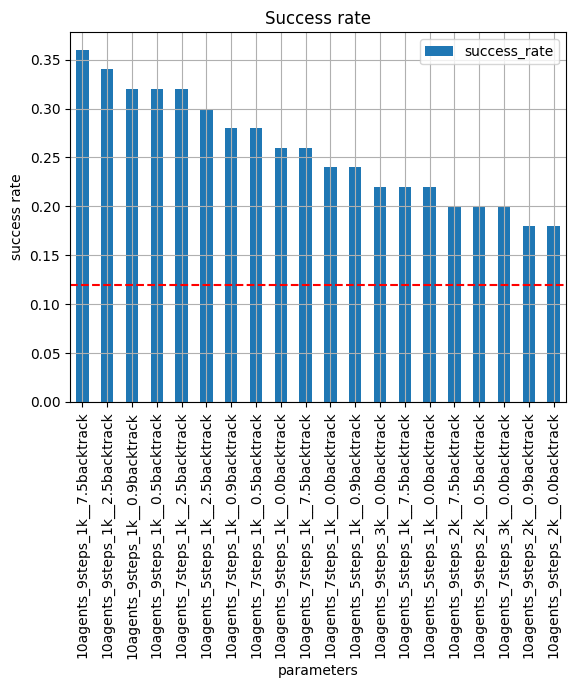

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()

df.plot(x="name", y="success_rate", kind="bar", title="Success Rate",)
# Adding a horizontal line
plt.axhline(y=0.12, color='r', linestyle='--')  # Adjust y value and other parameters as needed

plt.xlabel('parameters')
plt.ylabel('success rate')
plt.title('Success rate')
plt.grid(True)
plt.show()


<Figure size 640x480 with 0 Axes>

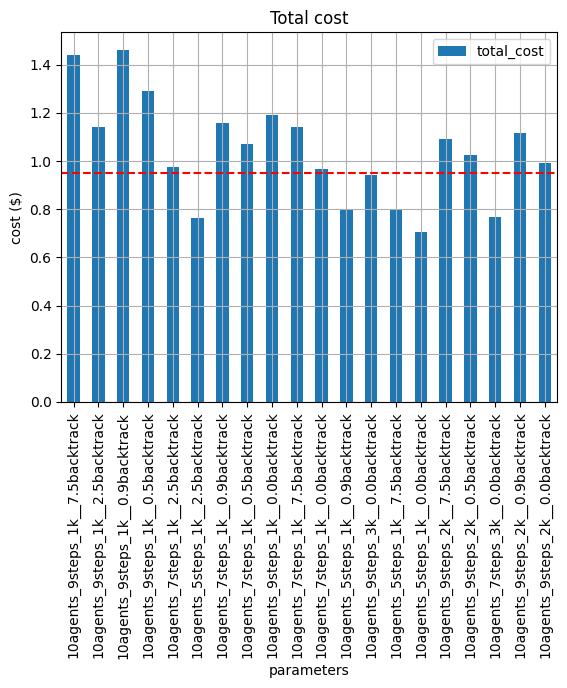

In [5]:
fig = plt.figure()

df.plot(x="name", y="total_cost", kind="bar", title="Cost",)
# Adding a horizontal line
plt.axhline(y=0.95, color='r', linestyle='--')  # Adjust y value and other parameters as needed

plt.xlabel('parameters')
plt.ylabel('cost ($)')
plt.title('Total cost')
plt.grid(True)
plt.show()

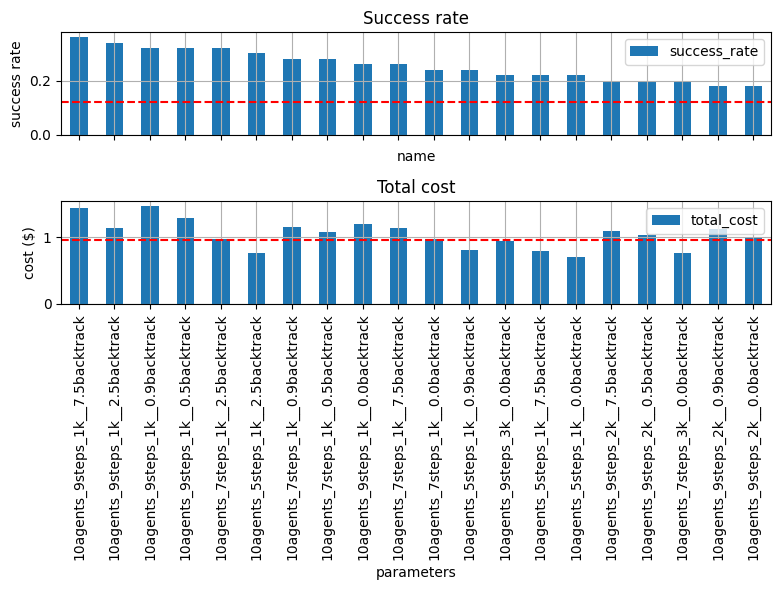

In [9]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the first dataset on the first subplot
df.plot(x="name", y="success_rate", kind="bar", title="Success Rate", ax=ax1)
ax1.axhline(y=0.12, color='r', linestyle='--')  # Adding a horizontal line
ax1.set_ylabel('success rate')
ax1.set_title('Success rate')
ax1.grid(True)
ax1.set_xticklabels([])  # Hide x-axis tick labels

# Plot the second dataset on the second subplot
df.plot(x="name", y="total_cost", kind="bar", title="Cost", ax=ax2)
ax2.axhline(y=0.95, color='r', linestyle='--')  # Adding a horizontal line
ax2.set_xlabel('parameters')
ax2.set_ylabel('cost ($)')
ax2.set_title('Total cost')
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
